# Latent Dirichlet Allocation (LDA) algorithm  
LDA это генеративная вероятностная модель, которая предполагает, что каждая тема представляет собой смесь какого-то определенного набора слов, а каждый документ/текст - смесь вероятностей тем. Краткая иллюстрация для интуитивного понимания работы алгоритма:    
<img src="lda.png">  
  
Теперь поясню, что происходит с математической точки зрения для M текстов с K (соответсвует n_components) топиками.  
<img src="lda1.png">  
1. Для каждого топика $k \in K$ строится $\beta_k$ ~ $Dirichlet(\eta)$. Соответсвует вероятности появления слова в топике k. ($\eta$ соотвутсвует topic_word_prior)  
2. Для каждого документа $d \in D$ строится $\theta$ ~ $Dirichlet(\alpha)$, где $\alpha$ соответсвует doc_topic_prior  
3. Для каждого слова $i \in d$ строится $z_{di} \sim \mathrm{Multinomial}
(\theta_d)$ и $w_{ij} \sim \mathrm{Multinomial}
(\beta_{z_{di}})$
  
Это алгоритм может использоваться для нескольких целей.   
1. Для **уменьшения рамзерности пространства** (как мы помним это нужно для визуализации данных или более быстрого обучения модели). В данном случае вместо представления текста T в его пространстве признаков как {Word_i: count(Word_i, T) for Word_i in Vocabulary}, мы можем представить его в пространстве тем как {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}.  
2. Для так называемого **Unsupervised Learning**, когда нам неизвестен таргет, а классификацию по какому-то правилу произвести надо. Мы можем разбивать текст на кластеры слов, и таким образом, текст будет представлять собой смесь всех тем, каждая из которых имеет определенный вес

### Unsupervised Learning  
**Вход**: M текстов по N слов в каждом. K - количество кластеов (топиков) на которые хотим разбить слова  
**Выход**: psi - распределение слов по каждой теме K; phi - распределение тем по каждому документу i  
**Параметры**: $\alpha$ - это параметр концентрации Дирихле, который показывает количество тем на один документ, т.е. чем выше данный параметр, тем большее количество тем представлено в документе. $\beta$ - параметр концентрации слов в топике, который показывает количество слов на одну тему

Рассмотрим на примере. Пусть нам даны следующие предложения (в примере забудем про ограниченность текстов по размеру):  
* I like to eat broccoli and bananas.
* I ate a banana and spinach smoothie for breakfast.
* Chinchillas and kittens are cute.
* My sister adopted a kitten yesterday.
* Look at this cute hamster munching on a piece of broccoli  
  
Если мы попросим LDA алгоритм распределить предложения по 2 темам, то он выдаст нам пимерно следующее:  

* Sentences 1: 100% Topic A
* Sentences 2: 100% Topic A
* Sentences 3: 100% Topic B
* Sentences 4: 100% Topic B
* Sentence 5: 60% Topic A, 40% Topic B  
Topic A: 30% broccoli, 15% bananas, 10% breakfast, 10% munching, … (= food)  
Topic B: 20% chinchillas, 20% kittens, 20% cute, 15% hamster, … (= cute animals)  
 

Теперь реализуем все вышесказанное в коде.  
xtract additive models of the topic structure of the corpus. The output is a plot of topics, each represented as bar plot using top few words based on weights.  
Загрузим набор данных, который представляет собой 11314 текстов, которые относятся к 20 группам по темам. Тут же преобразуем данные: избавимся от заголовков новостей, подписей и цитирования.

In [85]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000

print("Loading dataset...")
t0 = time()
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 1.902s.


Следующая функция будет визуализировать нам разделение на топики и концентрацию слов в каждом топике, а точнее вероятность того, что слово относится к данной теме. Далее будет понятней.

In [86]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


CountVectorizer создает вокабуляр V из указнного n_features слов, которые встречаются в тексте. Затем сопоставляет каждому тексту вектор, где на i-ой позиции стоит кол-во раз, которое V[i] слово встречается в данном тексте.

Extracting tf features for LDA...
done in 0.449s.


 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 3.938s.


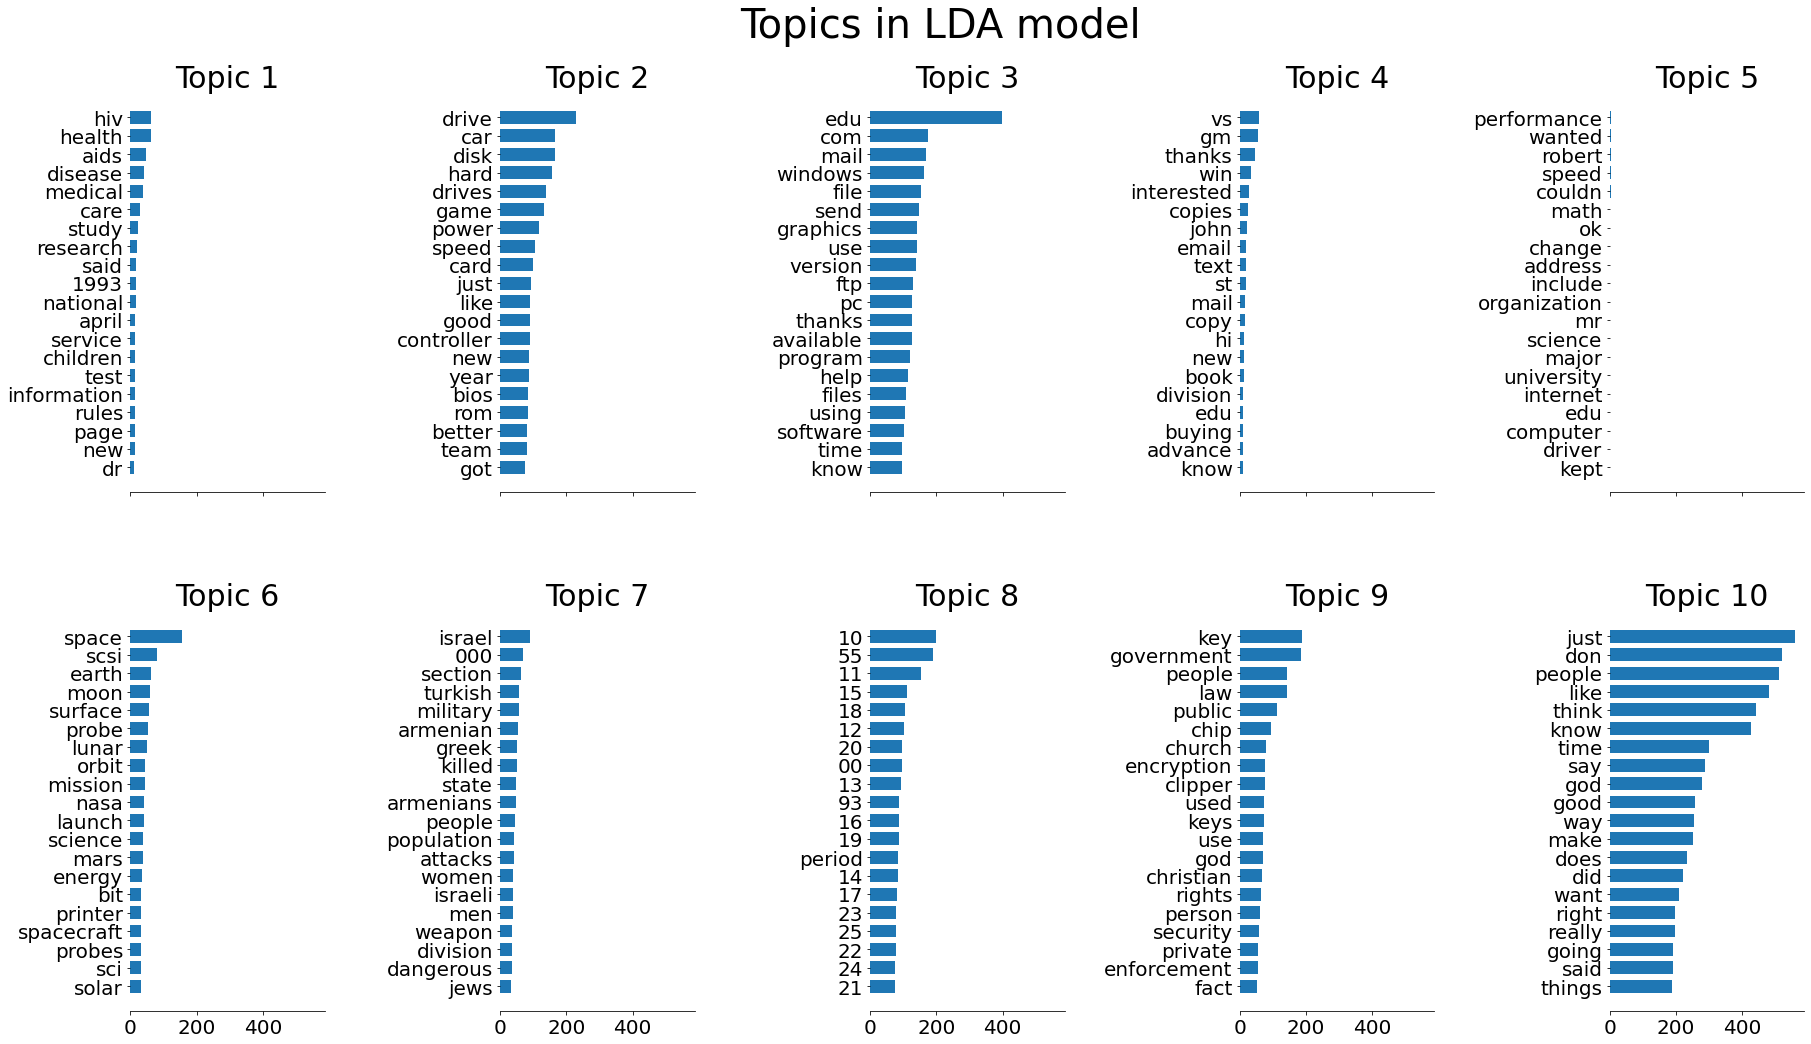

In [87]:
n_features = 1000
n_components = 10
n_top_words = 20

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

print( "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

Ресурсы:   
[Словесное описание работы LDA](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)  
[Реализация и примеры пименения работы LDA](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)  
[Еще одна реализация LDA](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)  
[Математическое объяснение работы LDA](https://scikit-learn.org/stable/modules/decomposition.html#decompositions)  
[Пример разделения на топики. Unsupervised Learning](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)  
[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation)